In [1]:
import pandas as pd
import altair as alt
from altair import datum
import numpy as np
from datetime import datetime as dt
from scipy.stats import ttest_ind
alt.data_transformers.disable_max_rows()

import baltic as bt
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import timedelta
import matplotlib.lines as mlines
import time
from io import StringIO
import altair as alt
import numpy as np
from zipfile import ZipFile



## exploring size of transmission clusters

In [2]:
new_clus =  "../mascot_glm/data/kc_clusters_combined_new.tsv"

In [3]:
clus_df = pd.read_csv(new_clus, sep="\t", parse_dates=  [3])

In [4]:
count_clusters = clus_df.groupby('new_clusters')["strain"].count().reset_index()
clus_df = clus_df.merge(count_clusters, on = "new_clusters")
clus_df = clus_df.rename(columns={"strain_x": "strain", "strain_y": "size_of_cluster"})

In [5]:
clus_df.head()

strain  cluster           location       date  \
0           USA/WA-UW-58813/2021        1  North_King_County 2021-01-29   
1           USA/WA-UW-67093/2021        2  South_King_County 2021-03-15   
2           USA/WA-UW-67915/2021        3  South_King_County 2021-03-16   
3              USA/WA-S6887/2021        4  South_King_County 2021-04-06   
4  USA/WA-CDC-UW21051428325/2021        5  South_King_County 2021-05-14   

  variant  is_unique  new_clusters  size_of_cluster  
0   alpha       True             1                1  
1   alpha       True             2                1  
2   alpha       True             3                1  
3   alpha       True             4                1  
4   alpha       True             5                1

In [6]:
foo_clus_df = clus_df[clus_df.size_of_cluster >9 ]

In [7]:
def check_same(group):
    return all(group == group.iloc[0])

# Group by 'group' and apply the check_same function
result = foo_clus_df.groupby('new_clusters')['location'].apply(check_same)

print(result.value_counts())

False    75
True     10
Name: location, dtype: int64


In [8]:
result = result.reset_index()

In [9]:
list_of_mono = result[result.location == True].new_clusters.values.tolist(); list_of_mono


[311, 1005, 1418, 2029, 4370, 4532, 4630, 4962, 5248, 5312]

In [10]:
clus_df[clus_df.new_clusters.isin( list_of_mono)]

strain  cluster           location  \
624                            USA/WA-S9059/2021      323  South_King_County   
625                    USA/WA-CDC-LC0045548/2021      323  South_King_County   
626                 USA/WA-UW-2021040882490/2021      323  South_King_County   
627   USA/WA-Altius-ALTCOV-AQU3XVNRJQWOWUX7/2021      323  South_King_County   
628                            USA/WA-S5866/2021      323  South_King_County   
...                                          ...      ...                ...   
9757                           USA/WA-S3522/2020      901  South_King_County   
9758                           USA/WA-S4144/2020      901  South_King_County   
9759                           USA/WA-S3477/2020      901  South_King_County   
9760                           USA/WA-S4157/2020      901  South_King_County   
9761                           USA/WA-S4153/2020      901  South_King_County   

           date variant  is_unique  new_clusters  size_of_cluster  
624  2021-03-28   alpha       True           311               21  
625  2021-04-17   alpha      False           311               21  
626  2021-04-08   alpha      False           311               21  
627  2021-04-12   alpha      False           311               21  
628  2021-03-20   alpha      False           311               21  
...         ...     ...        ...           ...              ...  
9757 2020-12-06   other      False          5312               10  
9758 2020-11-22   other      False          5312               10  
9759 2020-11-29   other      False          5312               10  
9760 2020-11-25   other      False          5312               10  
9761 2020-11-24   other      False          5312               10  

[136 rows x 8 columns]

In [11]:
#first we explore cluster size by variant
variants = list(clus_df.variant.unique())
final_cluster_df = pd.DataFrame()
for name in variants: 
    cluster_counts = pd.DataFrame()
    cluster_counts['count_clus'] = clus_df[clus_df['variant'] ==name].new_clusters.value_counts()
    cluster_counts = cluster_counts.reset_index()
    cluster_counts = cluster_counts.rename(columns={"index": "clusid", "count_clus": "size", "variant": "Variant"})
    cluster_counts["Variant"] = name

    final_cluster_df = pd.concat([ final_cluster_df, cluster_counts], ignore_index=True)

In [12]:
final_cluster_df.head()


clusid  size Variant
0     842    86   alpha
1     290    64   alpha
2     429    55   alpha
3     323    36   alpha
4     730    31   alpha

In [13]:
#final_cluster_df = final_cluster_df[final_cluster_df["size"] <405]

In [14]:
final_cluster_df = final_cluster_df[["size", "Variant"]]
df_size = pd.DataFrame(final_cluster_df.groupby('Variant', as_index = False).value_counts())#.reset_index()
df_size['perc'] = df_size.groupby('Variant')['count'].apply(lambda x: x/x.sum())


df_size.head()

Variant  size  count      perc
0   alpha     1    725  0.661496
1   alpha     2    131  0.119526
2   alpha     3     70  0.063869
3   alpha     4     54  0.049270
4   alpha     5     19  0.017336

In [15]:
log_clusters =  alt.Chart(df_size).mark_line(opacity = 1, interpolate = "monotone").encode(
    x=alt.X('size:Q', axis=alt.Axis(title="Cluster Size", grid=False)),
    y=alt.Y('perc:Q',  axis=alt.Axis(title="Log Frequency Distribution",labelFontSize= 14, titleFontSize = 12, grid=False, format='%'), scale=alt.Scale(type = "log", zero = True)),
    color = alt.Color("Variant:N", legend=alt.Legend(offset = -140,  labelFontSize = 14, titleFontSize = 12))).transform_filter(datum.size < 11).properties(
    width=300,
    height=200
)
log_clusters

alt.Chart(...)

In [16]:
#now we explore cluster size by region
cluster_counts_n = pd.DataFrame()
cluster_counts_s = pd.DataFrame()
cluster_counts_n['count_clus'] = clus_df[clus_df['location'] =="North_King_County"].new_clusters.value_counts()
cluster_counts_s['count_clus'] = clus_df[clus_df['location'] =="South_King_County"].new_clusters.value_counts()


In [17]:
cluster_counts_n = cluster_counts_n.reset_index()
cluster_counts_n = cluster_counts_n.rename(columns={"index": "clusid", "count_clus": "size", "location": "Region"})
cluster_counts_s = cluster_counts_s.reset_index()
cluster_counts_s = cluster_counts_s.rename(columns={"index": "clusid", "count_clus": "size", "location": "Region"})

cluster_counts_n["Region"] = "North King County"
cluster_counts_s["Region"] = "South King County"

In [18]:
concat_clus = pd.concat([ cluster_counts_n, cluster_counts_s], ignore_index=True)
#concat_clus
concat_clus = concat_clus[["size", "Region"]]
#test.to_csv("cluster_distribution.tsv",  sep="\t")

In [19]:
concat_clus.head()

size             Region
0   129  North King County
1    51  North King County
2    30  North King County
3    24  North King County
4    18  North King County

In [20]:
df_size = pd.DataFrame(concat_clus.groupby('Region', as_index = False).value_counts())#.reset_index()
df_size['perc'] = df_size.groupby('Region')['count'].apply(lambda x: x/x.sum())


df_size.head()


Region  size  count      perc
0  North King County     1   2886  0.776015
1  North King County     2    455  0.122345
2  North King County     3    171  0.045980
3  North King County     4     85  0.022856
4  North King County     5     40  0.010756

In [21]:
log_clusters =  alt.Chart(df_size).mark_line(opacity = 1, interpolate = "monotone").encode(
    x=alt.X('size:Q', axis=alt.Axis(title="Cluster Size", grid=False)),
    y=alt.Y('perc:Q',  axis=alt.Axis(title="Log Frequency Distribution",labelFontSize= 14, titleFontSize = 12, grid=False, format='%'), scale=alt.Scale(type = "log", zero = True)),
    color = alt.Color("Region:N", legend=alt.Legend(offset = -140,  labelFontSize = 14, titleFontSize = 12))).transform_filter(datum.size < 11).properties(
    width=300,
    height=200
)
log_clusters

alt.Chart(...)

In [22]:
linear_clusters =  alt.Chart(df_size).mark_line(opacity = 1, interpolate = "monotone").encode(
    x=alt.X('size:Q', axis=alt.Axis(title="Cluster Size", grid=False)),
    y=alt.Y('perc:Q',  axis=alt.Axis(title="Frequency Distribution",labelFontSize= 14, titleFontSize = 12, grid=False, format='%')),
    color = alt.Color("Region:N")).transform_filter(datum.size < 11).properties(
    width=300,
    height=200
)
linear_clusters

alt.Chart(...)

In [23]:
cluster_count = linear_clusters | log_clusters
cluster_count

alt.HConcatChart(...)

In [24]:
#calculate mean cluster size
df_size["contribution"] = df_size["size"] * df_size['perc']
df_size.groupby('Region')["contribution"].sum()

Region
North King County    1.545039
South King County    1.790689
Name: contribution, dtype: float64

In [25]:
#two sample t test for cluster size 
#define samples
group1 = concat_clus[concat_clus['Region']=='North King County']
group2 = concat_clus[concat_clus['Region']=='South King County']

#perform independent two sample t-test
ttest_ind(group1['size'], group2['size'])


Ttest_indResult(statistic=-3.283874513251606, pvalue=0.001029330607578431)

# now look at number of clusters over time for each region

In [26]:
date_clus = clus_df.groupby('new_clusters').first().reset_index()

In [27]:
date_clus

new_clusters                         strain  cluster           location  \
0                1           USA/WA-UW-58813/2021        1  North_King_County   
1                2           USA/WA-UW-67093/2021        2  South_King_County   
2                3           USA/WA-UW-67915/2021        3  South_King_County   
3                4              USA/WA-S6887/2021        4  South_King_County   
4                5  USA/WA-CDC-UW21051428325/2021        5  South_King_County   
...            ...                            ...      ...                ...   
5832          5833   USA/WA-UW-2021033005379/2021     1452  South_King_County   
5833          5834  USA/WA-CDC-UW21051960527/2021     1453  North_King_County   
5834          5835              USA/WA-S8491/2021     1454  South_King_County   
5835          5836  USA/WA-CDC-UW21050739083/2021     1455  South_King_County   
5836          5837  USA/WA-CDC-UW21050633664/2021     1456  North_King_County   

           date variant  is_unique  size_of_cluster  
0    2021-01-29   alpha       True                1  
1    2021-03-15   alpha       True                1  
2    2021-03-16   alpha       True                1  
3    2021-04-06   alpha       True                1  
4    2021-05-14   alpha       True                1  
...         ...     ...        ...              ...  
5832 2021-03-30   other       True                2  
5833 2021-05-19   other       True                1  
5834 2021-05-22   other       True                1  
5835 2021-05-07   other       True                1  
5836 2021-05-06   other       True                2  

[5837 rows x 8 columns]

In [28]:
def convert_format(number):
    #date = dt.strptime(number, '%Y-%m-%d')
    date = dt.strftime(number, '%Y-%m')
    return date

In [29]:
date_clus['year-month'] = date_clus['date'].map(convert_format)

In [30]:
date_clus

new_clusters                         strain  cluster           location  \
0                1           USA/WA-UW-58813/2021        1  North_King_County   
1                2           USA/WA-UW-67093/2021        2  South_King_County   
2                3           USA/WA-UW-67915/2021        3  South_King_County   
3                4              USA/WA-S6887/2021        4  South_King_County   
4                5  USA/WA-CDC-UW21051428325/2021        5  South_King_County   
...            ...                            ...      ...                ...   
5832          5833   USA/WA-UW-2021033005379/2021     1452  South_King_County   
5833          5834  USA/WA-CDC-UW21051960527/2021     1453  North_King_County   
5834          5835              USA/WA-S8491/2021     1454  South_King_County   
5835          5836  USA/WA-CDC-UW21050739083/2021     1455  South_King_County   
5836          5837  USA/WA-CDC-UW21050633664/2021     1456  North_King_County   

           date variant  is_unique  size_of_cluster year-month  
0    2021-01-29   alpha       True                1    2021-01  
1    2021-03-15   alpha       True                1    2021-03  
2    2021-03-16   alpha       True                1    2021-03  
3    2021-04-06   alpha       True                1    2021-04  
4    2021-05-14   alpha       True                1    2021-05  
...         ...     ...        ...              ...        ...  
5832 2021-03-30   other       True                2    2021-03  
5833 2021-05-19   other       True                1    2021-05  
5834 2021-05-22   other       True                1    2021-05  
5835 2021-05-07   other       True                1    2021-05  
5836 2021-05-06   other       True                2    2021-05  

[5837 rows x 9 columns]

In [31]:
variant_date_df = date_clus.groupby(["year-month","location", "variant"])["size_of_cluster"].mean().reset_index(); variant_date_df

year-month           location  variant  size_of_cluster
0     2020-02  North_King_County    other         3.600000
1     2020-03  North_King_County    other         1.716418
2     2020-03  South_King_County    other         1.564103
3     2020-04  North_King_County    other         2.000000
4     2020-04  South_King_County    other         2.454545
..        ...                ...      ...              ...
82    2022-02  North_King_County  omicron         1.480769
83    2022-02  South_King_County  omicron         1.512987
84    2022-03  North_King_County  omicron         1.512953
85    2022-03  North_King_County    other         2.500000
86    2022-03  South_King_County  omicron         1.697674

[87 rows x 4 columns]

In [32]:
date_clus.location[date_clus.location == "North_King_County"] = "North King County"
date_clus.location[date_clus.location == "South_King_County"] = "South King County"

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_60976/1765852014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_clus.location[date_clus.location == "North_King_County"] = "North King County"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_60976/1765852014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_clus.location[date_clus.location == "South_King_County"] = "South King County"


In [33]:
clust_over_time_kc =  alt.Chart(date_clus).mark_bar(opacity = 1, interpolate='monotone', size = 10).encode(
    alt.X('year-month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('count():Q', axis=alt.Axis(title="Number of Local Outbreak Clusters", grid=False, labelFontSize = 14), stack = None), 
    alt.Color("location:N", legend = None), 
    column= alt.Column("location:N", title = None, spacing = 70, header=alt.Header(labelFontSize = 14))
).properties(
    width=300,
    height=200
)
clust_over_time_kc

alt.Chart(...)

In [34]:
clust_over_time =  alt.Chart(date_clus).mark_bar(opacity = 1, interpolate='monotone', size = 10).encode(
    alt.X('year-month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('count():Q', axis=alt.Axis(title="Number of Local Outbreak Clusters", grid=False, labelFontSize = 14), stack = None), 
    alt.Color("variant:N"), 
    column= alt.Column("location:N", title = None, spacing = 70, header=alt.Header(labelFontSize = 14))
).properties(
    width=300,
    height=200
)

In [35]:
clust_over_time

alt.Chart(...)

In [39]:
clust_over_time =  alt.Chart(variant_date_df).mark_line(opacity = 1, interpolate='monotone',).encode(
    alt.X('year-month:O', axis = alt.Axis(grid= False,  title = "")),
    alt.Y('size_of_cluster:Q', axis=alt.Axis(title="Mean Size of Local Outbreak Clusters", grid=False, labelFontSize = 14,), stack = None), 
    alt.Color("variant:N"), 
    row= alt.Row("location:N", title = None, spacing = 15, header=alt.Header(labelFontSize = 14))
).transform_filter(datum.size_of_cluster <10)
clust_over_time

alt.Chart(...)

In [37]:
clust_over_time =  alt.Chart(variant_date_df).mark_line(opacity = 1, interpolate='monotone',).encode(
    alt.X('year-month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('size_of_cluster:Q', axis=alt.Axis(title="Mean Size of Local Outbreak Clusters", grid=False, labelFontSize = 14,), stack = None), 
    alt.Color("variant:N"), 
    column= alt.Column("location:N", title = None, spacing = 70, header=alt.Header(labelFontSize = 14))
).transform_filter(datum.size_of_cluster <10)


clust_over_time

alt.Chart(...)

In [50]:
date_clus

new_clusters                                      strain  cluster  \
0                1                  USA/WA-UW-21050529358/2021        1   
1                2                  USA/WA-UW-21050476716/2021        2   
2                3                USA/WA-UW-2021041397284/2021        3   
3                4                        USA/WA-UW-65398/2021        4   
4                5                        USA/WA-UW-69277/2021        5   
...            ...                                         ...      ...   
5959          5960  USA/WA-Altius-ALTCOV-BEQRS2ML7ZX3EQWJ/2021     1421   
5960          5961                           USA/WA-S2728/2020     1422   
5961          5962               USA/WA-CDC-UW22030161746/2022     1423   
5962          5963               USA/WA-CDC-UW22030214877/2022     1424   
5963          5964               USA/WA-CDC-UW22022865732/2022     1425   

               location       date variant  is_unique  size_of_cluster  \
0     North King County 2021-05-05   alpha       True                1   
1     North King County 2021-05-04   alpha       True                1   
2     North King County 2021-04-13   alpha       True                3   
3     North King County 2021-02-27   alpha       True                1   
4     South King County 2021-03-26   alpha       True                1   
...                 ...        ...     ...        ...              ...   
5959  South King County 2021-07-09   other       True                3   
5960  North King County 2020-07-08   other       True                2   
5961  North King County 2022-03-01   other       True                1   
5962  North King County 2022-03-02   other       True                2   
5963  North King County 2022-02-28   other       True                2   

     year-month  
0       2021-05  
1       2021-05  
2       2021-04  
3       2021-02  
4       2021-03  
...         ...  
5959    2021-07  
5960    2020-07  
5961    2022-03  
5962    2022-03  
5963    2022-02  

[5964 rows x 9 columns]

In [51]:
#adding labels
clust_over_time_kc = clust_over_time_kc.properties(title = "A")
cluster_count = cluster_count.properties(title = "B")

clus_des = (clust_over_time_kc & cluster_count).resolve_scale(color = "independent")
clus_des.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 30
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_legend(
    labelFontSize = 14)

alt.VConcatChart(...)

In [52]:
#clus_des.save("../figures/clust_over_time.html")

In [53]:
### working on MCC tree for part 2C

In [41]:
tree12=bt.loadNexus('../analysis/data-files/mcc_tree_random_3000.trees', absoluteTime = False)
tree12.setAbsoluteTime(2022.1753424657534)

In [42]:
clist=[(0.0,'#3B76AF'),
       (0.5,'grey'),
       (1.0,'#E68033')]

host_cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)

In [43]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [44]:
for k in tree12.Objects:
    if "typeTrait.set" not in k.traits:
        k.traits.update({'typeTrait.set': []})
    if "typeTrait" not in k.traits:
        k.traits.update({'typeTrait': []})
    if k.traits['typeTrait'] == []:
        k.traits.update({'typeTrait': 'none'})

In [45]:
division_order = ['North_King_County', 'South_King_County']
exclusions = ['none', 'root', 'ancestor']

In [46]:
##this can be used to find root locations and make predefined clusters into individual subtrees.
def enumerate_subtrees_clusters(tree):
    
    traitName="typeTrait"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees=[]

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if (kloc != kploc) & (kploc in exclusions):      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName] in division_order     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()

                #tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees.append((kploc, kloc, subtree))
    
    return(subtype_trees)

In [47]:
subtype_trees = enumerate_subtrees_clusters(tree12)


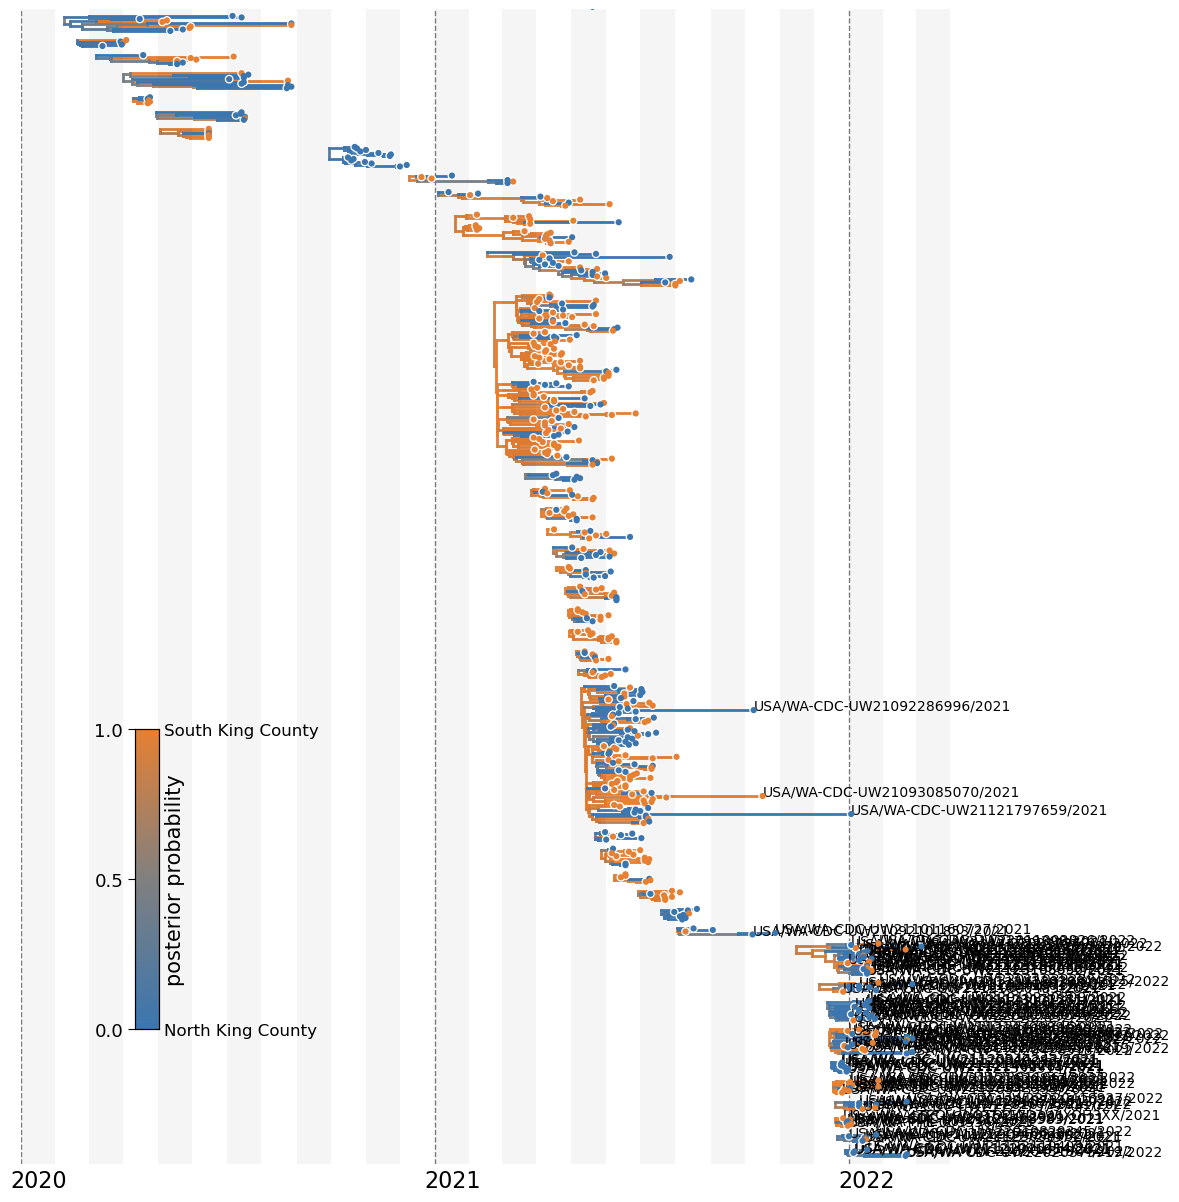

In [68]:
fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
cumulativeY=0
branchWidth=2
for t,tr in enumerate(sorted(subtype_trees,key=lambda x:(-x[2].root.absoluteTime))): ## iterate over extracted subtrees sorted according to their root height and their size
    origin,root,loc_tree=tr

    for k in loc_tree.Objects:
        c='k'
        if 'South_King_County' in k.traits['typeTrait.set']:
            hidx=k.traits['typeTrait.set'].index('South_King_County')
            c=host_cmap(k.traits['typeTrait.set.prob'][hidx])
        else:
            c=host_cmap(0.0)

        z=1
        if k.traits['typeTrait']=='North_King_County':
            z=2

        x=k.absoluteTime
        y=k.y+cumulativeY

        xp=k.parent.absoluteTime
        if xp==0:
            xp=x

        if k.branchType=='leaf':
            ax.scatter(x,y,s=20,facecolor=c,edgecolor='none',zorder=4)
            ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
#             if x > 2021.7:
#                 ax.annotate(k.name, (x,y))
        else:
            yl=k.children[0].y+cumulativeY
            yr=k.children[-1].y+cumulativeY
            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)

        if loc_tree.Objects.index(k)!=0:
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)
    cumulativeY+=loc_tree.ySpan+5

every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2019,2023) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2019,2023)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2020-01-01'),bt.decimalDate('2022-04-01'))
ax.set_ylim(-5,cumulativeY -15)

ax2 = fig.add_axes([0.22, 0.2, 0.02, 0.2])
mpl.colorbar.ColorbarBase(ax2, cmap=host_cmap,ticks=np.linspace(0.0,1.0,3))
ax2.tick_params(size=5,labelsize=13)
ax2.set_ylabel('posterior probability', size=15)
ax3=ax2.twinx()
ax3.set_ylim(0,1)
ax3.set_yticks([0.0,1.0])
ax3.set_yticklabels(['North King County','South King County'])
ax3.tick_params(size=0,labelsize=12)
plt.savefig('../figures/mcc_clusters_size_5.png',dpi=300,bbox_inches='tight')
plt.show()